# Project Milestone Two

**Data Preparation and Model Exploration**
**Due:** Midnight on November 16th with usual 2-hour grace period — **worth 100 points**

**Note: No late assignments accepted, we need the time to grade them!**

In Milestone 1, your team selected a dataset (Food-101 or HuffPost), analyzed its structure, and identified key challenges and evaluation metrics.
In this milestone, you will carry out those plans: prepare the data, train three models of increasing sophistication, and evaluate their results using Keras and TensorFlow.
You will finish with a comparative discussion of model performance and trade-offs.


### Submission Guidelines

* Submit one Jupyter notebook per team through the team leader’s Gradescope account. **Include all team members names at the top of the notebook.**
* Include all code, plots, and answers inline below.
* Ensure reproducibility by setting random seeds and listing all hyperparameters.
* Document any AI tools used, as required by the CDS policy.


## Problem 1 – Data Preparation and Splits (20 pts)

### Goals

Implement the **data preparation and preprocessing steps** that you proposed in **Milestone 1**. You’ll clean, normalize, and split your data so that it’s ready for modeling and reproducible fine-tuning.

### Steps to Follow

1. **Load your chosen dataset**

   * Use `datasets.load_dataset()` from **Hugging Face** to load **Food-101** or **HuffPost**.
   * Display basic information (e.g., number of samples, feature names, example entries).

2. **Apply cleaning and normalization**

   * **Images:**

     * Ensure all images are in RGB format.
     * Resize or crop to a consistent shape (e.g., `224 × 224`).
     * Drop or fix any corrupted files.
   * **Text:**

     * Concatenate headline + summary (for HuffPost).
     * Strip whitespace, convert to lowercase if appropriate, and remove empty samples.
     * Optionally remove duplicates or extremely short entries.

3. **Standardize or tokenize the inputs**

   * **Images:**

     * Normalize pixel values (e.g., divide by 255.0).
     * Define a minimal augmentation pipeline (e.g., random flip, crop, or rotation).
   * **Text:**

     * Create a tokenizer or `TextVectorization` layer.
     * Set a target `max_length` based on your analysis from Milestone 1 (e.g., 95th percentile).
     * Apply padding/truncation and build tensors for input + labels.

4. **Handle dataset-specific challenges**

   * If you identified **class imbalance**, compute label counts and, if needed, create a dictionary of `class_weights`.
   * If you noted **length or size variance**, verify that your truncation or resizing works as intended.
   * If you planned **noise filtering**, include the cleaning step and briefly explain your criteria (e.g., remove items with missing text or unreadable images).

5. **Create reproducible splits**

   * Split your cleaned dataset into **train**, **validation**, and **test** subsets (e.g., 80 / 10 / 10).
   * Use a fixed random seed for reproducibility (`random_seed = 42`).
   * Use **stratified splits**  (e.g., with `train_test_split` and `stratify = labels`).
   * Display the size of each subset.

6. **Document your pipeline**

   * Summarize your preprocessing steps clearly in Markdown or code comments.
   * Save or display a few representative examples after preprocessing to confirm the transformations are correct.




In [ ]:
# imports and seeds

import os, random
import numpy as np
import pandas as pd
from datasets import load_dataset
import keras

import tensorflow as tf
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.layers import (
    Dense, Dropout, Flatten, MaxPooling2D, Conv2D,
    SeparableConv2D, GlobalAveragePooling2D, GlobalMaxPooling2D, BatchNormalization
)



from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)



In [ ]:
# step 1: load dataset

# JSON mirror that preserves fields: headline, short_description, category, authors, link, date
URL = "https://huggingface.co/datasets/khalidalt/HuffPost/resolve/main/News_Category_Dataset_v2.json"
huff_all = load_dataset("json", data_files=URL, split="train")

print(huff_all)
print("Columns:", huff_all.column_names)
print("Total rows:", len(huff_all))

# to pandas for the rest of pipeline
df = huff_all.to_pandas()
df = df[["headline","short_description","category","authors","link","date"]].copy()

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


News_Category_Dataset_v2.json:   0%|          | 0.00/83.9M [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset({
    features: ['category', 'headline', 'authors', 'link', 'short_description', 'date'],
    num_rows: 200853
})
Columns: ['category', 'headline', 'authors', 'link', 'short_description', 'date']
Total rows: 200853


In [ ]:
# step 2: cleaning and normalization

def clean_text(s):
    if not isinstance(s, str):
        return ""
    s = s.strip().lower()
    return " ".join(s.split())

# Concatenate headline + summary, then clean
text = (df["headline"].fillna("") + " " + df["short_description"].fillna("")).apply(clean_text)

# Remove empty samples and drop exact duplicates
mask_nonempty = text.str.len() > 0
df = df.loc[mask_nonempty].copy()
df["text"] = text.loc[mask_nonempty]
before = len(df)
df = df.drop_duplicates(subset=["text"]).reset_index(drop=True)
after = len(df)
print(f"Removed {before - after} duplicate rows; remaining = {after}")

# Format category columns to amerliorate any weird strings
df["category"] = (
    df["category"]
    .fillna("")
    .str.strip()
    .str.upper()
    .str.replace("’", "'", regex=False)
    .str.replace(r"\s+", " ", regex=True)
)

# Consolidate Classes from Milestone 1
map_to = {
    # Arts & Entertainment
    "ARTS":           "ARTS & ENTERTAINMENT",
    "ARTS & CULTURE": "ARTS & ENTERTAINMENT",
    "CULTURE & ARTS": "ARTS & ENTERTAINMENT",
    "ENTERTAINMENT":  "ARTS & ENTERTAINMENT",

    # Health & Wellness
    "WELLNESS":       "HEALTH & WELLNESS",
    "HEALTHY LIVING": "HEALTH & WELLNESS",

    # Food & Drink
    "FOOD & DRINK":   "FOOD & DRINK",
    "FOOD & DRINK.":  "FOOD & DRINK",
    "TASTE":          "FOOD & DRINK",

    # Family & Relationships
    "PARENTING":    "FAMILY & RELATIONSHIPS",
    "PARENTS":      "FAMILY & RELATIONSHIPS",
    "DIVORCE":      "FAMILY & RELATIONSHIPS",
    "WEDDINGS":     "FAMILY & RELATIONSHIPS",

    # World News
    "WORLDPOST":     "WORLD NEWS",
    "THE WORLDPOST": "WORLD NEWS",

    # Environment
    "GREEN": "ENVIRONMENT",

    # Business & Money
    "BUSINESS": "BUSINESS & MONEY",
    "MONEY":    "BUSINESS & MONEY",

    # Education
    "COLLEGE":  "EDUCATION",
}


# Replace using the mapping, leave others untouched
df["label_str"] = df["category"].replace(map_to)

df = df[["text","label_str","authors","link","date"]]
df.head(3)


Removed 492 duplicate rows; remaining = 200356


,text,label_str,authors,link,date
0,there were 2 mass shootings in texas last week...,CRIME,Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-ama...,2018-05-26
1,will smith joins diplo and nicky jam for the 2...,ARTS & ENTERTAINMENT,Andy McDonald,https://www.huffingtonpost.com/entry/will-smit...,2018-05-26
2,hugh grant marries for the first time at age 5...,ARTS & ENTERTAINMENT,Ron Dicker,https://www.huffingtonpost.com/entry/hugh-gran...,2018-05-26


Sanity Check:

In [ ]:
print("Unique labels (after consolidation):", len(df["label_str"].unique()))
print(df["label_str"].value_counts().head(15))
print("Any empty texts left? ", (df["text"].str.len()==0).sum())

Unique labels (after consolidation): 28
label_str
POLITICS                  32721
HEALTH & WELLNESS         24510
ARTS & ENTERTAINMENT      19930
FAMILY & RELATIONSHIPS    19618
TRAVEL                     9883
STYLE & BEAUTY             9512
WORLD NEWS                 8418
FOOD & DRINK               8320
BUSINESS & MONEY           7639
QUEER VOICES               6310
COMEDY                     5163
SPORTS                     4884
BLACK VOICES               4523
HOME & LIVING              4161
ENVIRONMENT                3939
Name: count, dtype: int64
Any empty texts left?  0


In [ ]:
# step 3: Label encoding, length stats, tokenizer setup

# Encode categories (stable, alphabetical ordering)
cats = sorted(df["label_str"].unique())
cat2id = {c:i for i,c in enumerate(cats)}
id2cat = {i:c for c,i in cat2id.items()}
df["label"] = df["label_str"].map(cat2id).astype(int)

# Sequence length choice from empirical distribution (95th percentile)
token_counts = df["text"].str.split().apply(len)
p95 = int(np.percentile(token_counts, 95))

MAX_TOKENS = 30000
MAX_LENGTH = max(16, min(96, p95))  # headlines+short_desc rarely need >96

print(f"Classes: {len(cats)} | MAX_TOKENS={MAX_TOKENS} | p95={p95} → MAX_LENGTH={MAX_LENGTH}")
print(df["label_str"].value_counts().head(10))

# Vectorizer — adapted on TRAIN ONLY later to avoid leakage
vectorize = TextVectorization(
    max_tokens=MAX_TOKENS,
    output_mode="int",
    output_sequence_length=MAX_LENGTH,
    standardize=None,
    split="whitespace",
)

Classes: 28 | MAX_TOKENS=30000 | p95=56 → MAX_LENGTH=56
label_str
POLITICS                  32721
HEALTH & WELLNESS         24510
ARTS & ENTERTAINMENT      19930
FAMILY & RELATIONSHIPS    19618
TRAVEL                     9883
STYLE & BEAUTY             9512
WORLD NEWS                 8418
FOOD & DRINK               8320
BUSINESS & MONEY           7639
QUEER VOICES               6310
Name: count, dtype: int64


In [ ]:
# step 5: Reproducible stratified 80/10/10 splits

X = df["text"].values
y = df["label"].values

# Train vs temp (val+test)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.20, random_state=SEED, stratify=y
)
# Val vs test = 50/50 of temp → overall 10/10
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=SEED, stratify=y_temp
)

print(f"Train/Val/Test sizes: {len(X_train)} / {len(X_val)} / {len(X_test)}")


Train/Val/Test sizes: 160284 / 20036 / 20036


In [ ]:
# step 4: class imbalance handling
classes = np.arange(len(cats))
cw_arr = compute_class_weight(class_weight="balanced", classes=classes, y=y_train)
CLASS_WEIGHTS = {int(c): float(w) for c, w in zip(classes, cw_arr)}
list(CLASS_WEIGHTS.items())[:10]


[(0, 0.35903340262346783),
 (1, 1.582208007581142),
 (2, 0.9367417069920752),
 (3, 1.386060186786579),
 (4, 2.1037958733658844),
 (5, 3.332030600365874),
 (6, 1.8167021807136057),
 (7, 0.3647526807333103),
 (8, 5.106537530266344),
 (9, 0.8600403502747253)]

In [ ]:
# step 6: tf.data pipelines & sanity checks

# Adapt vectorizer on TRAIN ONLY
vectorize.adapt(tf.data.Dataset.from_tensor_slices(X_train).batch(1024))

# Vectorize to integer tensors
Xtr_int = vectorize(tf.constant(X_train))
Xva_int = vectorize(tf.constant(X_val))
Xte_int = vectorize(tf.constant(X_test))

ytr = tf.constant(y_train, dtype=tf.int32)
yva = tf.constant(y_val,   dtype=tf.int32)
yte = tf.constant(y_test,  dtype=tf.int32)

Xtr_int.shape, Xva_int.shape, Xte_int.shape

BATCH = 128
AUTOTUNE = tf.data.AUTOTUNE

def make_ds(X_int, y):
    ds = tf.data.Dataset.from_tensor_slices((X_int, y))
    ds = ds.shuffle(10_000, seed=SEED, reshuffle_each_iteration=False)
    ds = ds.batch(BATCH).prefetch(AUTOTUNE)
    return ds

ds_train = make_ds(Xtr_int, ytr)
ds_val   = make_ds(Xva_int, yva)
ds_test  = tf.data.Dataset.from_tensor_slices((Xte_int, yte)).batch(BATCH).prefetch(AUTOTUNE)

# quick sanity prints
for xs, ys in ds_train.take(1):
    print("Batch:", xs.shape, ys.shape, " | example label id:", int(ys[0].numpy()))




Batch: (128, 56) (128,)  | example label id: 9


### Graded Questions (5 pts each)

For each question, answer thoroughly but concisely, in a short paragraph, longer or shorter as needed. Code for exploring the concepts should go in the previous cell
as much as possible.

1. **Data Loading and Cleaning:**
   Describe how you loaded your dataset and the key cleaning steps you implemented (e.g., handling missing data, normalizing formats, or removing duplicates).



1.1. **Your answer here:**

We loaded HuffPost via the same JSON mirror used in Milestone 1 using load_dataset("json", data_files=URL, split="train"), preserving the original fields (headline, short_description, category, authors, link, date). The raw dataset contains 200,853 rows and 41 categories.
Cleaning steps: concatenated headline + short_description, lowercased/trimmed whitespace, removed empty texts, and dropped exact-duplicate texts. This removed 492 duplicates, leaving 200,356 samples for modeling. Additionally, class labels were consolidated as specified in Milestone 1 (with categories like Arts, Arts & Culture, and Culture & Arts identified as having a high Jaccard Similarity). Finally, we retained authors/link/date for documentation only (not used as inputs).



2. **Preprocessing and Standardization:**
   Summarize your preprocessing pipeline. Include any normalization, tokenization, resizing, or augmentation steps, and explain why each was necessary for your dataset.
  

1.2. **Your answer here:**

Inputs are text only. We tokenize with a Keras TextVectorization layer configured with max_tokens=30,000 and fixed output_sequence_length=56. The max length (56) comes from the 95th percentile of token counts computed on the cleaned corpus, which balances coverage vs. truncation cost for headline+summary pairs. Standardization (lowercasing/whitespace collapse) happened in our custom cleaner to match Milestone 1; the vectorizer’s standardize=None avoids double processing. The vectorizer is adapted on the training split only to prevent leakage.

3. **Train/Validation/Test Splits:**
   Explain how you divided your data into subsets, including the split ratios, random seed, and any stratification or leakage checks you used to verify correctness.


1.3. **Your answer here:**

We created reproducible, stratified splits with random_state=42: 80% train / 10% val / 10% test, yielding 160,284 / 20,036 / 20,036 samples. Stratification is by label to preserve class proportions across splits. We verified shapes after vectorization: (160,284, 56), (20,036, 56), (20,036, 56) for X, with integer label tensors for y. The vectorizer was adapted on train only, then applied to val/test.


4. **Class Distribution and Balance:**
   Report your label counts and describe any class imbalances you observed. If applicable, explain how you addressed them (e.g., weighting, oversampling, or data augmentation).


1.4. **Your answer here:**

After label consolidation there are 28 classes with a long-tail distribution (e.g., top categories: POLITICS 32,721; HEALTH & WELLNESS 24,510; ARTS & ENTERTAINMENT 19,930; ...). To mitigate imbalance during training we computed class weights on the training set using compute_class_weight("balanced", ...). We will pass class_weight=CLASS_WEIGHTS to Keras model.fit. (Weights span roughly ~0.82 to ~4.87 across classes in our run.)

## Problem 2 – Baseline Model (20 pts)

### Goal

Build and train a **simple, fully functional baseline model** to establish a reference level of performance for your dataset.
This baseline will help you evaluate whether later architectures and fine-tuning steps actually improve results.


### Steps to Follow

1. **Construct a baseline model**

   * **Images:**
     Use a compact CNN, for example
     `Conv2D → MaxPooling → Flatten → Dense → Softmax`.
   * **Text:**
     Use a small embedding-based classifier such as
     `Embedding → GlobalAveragePooling → Dense → Softmax`.
   * Keep the model small enough to train in minutes on Colab.

2. **Compile the model**

   * Optimizer: `Adam` or `AdamW`.
   * Loss: `categorical_crossentropy` (for multi-class).
   * Metrics: at least `accuracy`; add `F1` if appropriate.

3. **Train and validate**

   * Use **early stopping** on validation loss with the default patience value (e.g., 5 epochs).
   * Record number of epochs trained and total runtime.

4. **Visualize results**

   * Plot **training vs. validation accuracy and loss**.
   * Carefully observe: does the model underfit, overfit, or generalize reasonably?

5. **Report baseline performance**

   * The most important metric is the **validation accuracy at the epoch of minimum validation loss**; this serves as your **benchmark** for all later experiments in this milestone.
   * Evaluate on the **test set** and record final metrics.

In [ ]:
# step 1: Constructing a simple baseline (Embedding -> GlobalAvgPool -> Dense -> Softmax)

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

NUM_CLASSES = len(cats)

baseline = keras.Sequential([
    layers.Input(shape=(MAX_LENGTH,)),                      # integer tokens (from TextVectorization)
    layers.Embedding(input_dim=MAX_TOKENS, output_dim=64),  # small, fast
    layers.GlobalAveragePooling1D(),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(NUM_CLASSES, activation="softmax")
], name="baseline_emb_avgpool")

baseline.summary()



Model: "baseline_emb_avgpool"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 56, 64)         │     1,920,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 28)             │         3,612 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,931,932 (7.37 MB)

 Trainable params: 1,931,932 (7.37 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# step 2: Compile (Adam, sparse categorical cross-entropy, accuracy)

# We keep integer labels, so we use SparseCategoricalCrossentropy (same objective as categorical CE but without one-hotting).

baseline.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"]
)


In [ ]:
# step 3: Train with EarlyStopping on val_loss (patience=20) + runtime

import time
early_stop = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=20,
    restore_best_weights=True
)

start = time.time()
hist = baseline.fit(
    ds_train,
    validation_data=ds_val,
    epochs=100,                      # small model should converge quickly
    class_weight=CLASS_WEIGHTS,     # from Problem 1
    callbacks=[early_stop],
    verbose=1
)
runtime_sec = time.time() - start
print(f"Training runtime: {runtime_sec/60:.2f} minutes | epochs trained: {len(hist.history['loss'])}")


Epoch 1/100


2025-11-10 14:59:05.210330: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


1253/1253 ━━━━━━━━━━━━━━━━━━━━ 15s 11ms/step - accuracy: 0.2364 - loss: 2.8305 - val_accuracy: 0.4002 - val_loss: 2.1735
Epoch 2/100
1253/1253 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.4704 - loss: 1.9600 - val_accuracy: 0.4873 - val_loss: 1.8174
Epoch 3/100
1253/1253 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.5580 - loss: 1.5404 - val_accuracy: 0.5272 - val_loss: 1.7030
Epoch 4/100
1253/1253 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.6098 - loss: 1.2968 - val_accuracy: 0.5512 - val_loss: 1.6492
Epoch 5/100
1253/1253 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.6481 - loss: 1.1153 - val_accuracy: 0.5689 - val_loss: 1.6221
Epoch 6/100
1253/1253 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.6774 - loss: 0.9692 - val_accuracy: 0.5769 - val_loss: 1.6212
Epoch 7/100
1253/1253 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.7040 - loss: 0.8494 - val_accuracy: 0.5825 - val_loss: 1.6413
Epoch 8/100
1253/1253 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.7278 - los

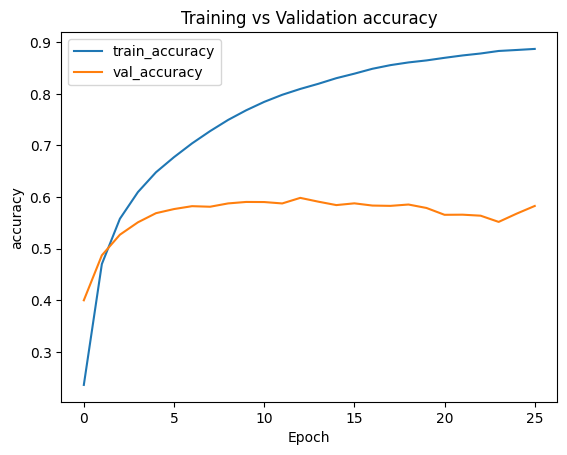

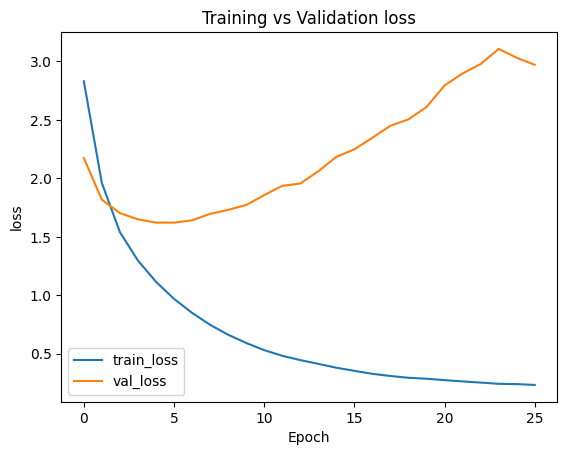

In [ ]:
# step 4: Plot training vs validation curves (accuracy & loss)

import matplotlib.pyplot as plt

def plot_history(history, key="accuracy"):
    plt.figure()
    plt.plot(history.history[key], label=f"train_{key}")
    plt.plot(history.history[f"val_{key}"], label=f"val_{key}")
    plt.xlabel("Epoch")
    plt.ylabel(key)
    plt.legend()
    plt.title(f"Training vs Validation {key}")

plot_history(hist, "accuracy")
plot_history(hist, "loss")


In [ ]:
# step 5: Evaluate on test set and compute optional macro-F1

from sklearn.metrics import classification_report, f1_score

test_loss, test_acc = baseline.evaluate(ds_test, verbose=0)
print(f"Test Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.4f}")

# Predictions → macro-F1 (optional but useful we believe)
y_true = []
y_pred = []
for x_batch, y_batch in ds_test:
    logits = baseline.predict(x_batch, verbose=0)
    y_true.extend(y_batch.numpy().tolist())
    y_pred.extend(np.argmax(logits, axis=1).tolist())

macro_f1 = f1_score(y_true, y_pred, average="macro")
print(f"Macro F1 (test): {macro_f1:.4f}")

# Short report
print(classification_report(y_true, y_pred, target_names=[id2cat[i] for i in range(NUM_CLASSES)], digits=3))


Test Loss: 1.6212 | Test Accuracy: 0.5794
Macro F1 (test): 0.4940
                        precision    recall  f1-score   support

  ARTS & ENTERTAINMENT      0.645     0.590     0.616      1993
          BLACK VOICES      0.316     0.555     0.403       452
      BUSINESS & MONEY      0.423     0.588     0.492       764
                COMEDY      0.376     0.490     0.426       516
                 CRIME      0.475     0.553     0.511       340
             EDUCATION      0.292     0.600     0.393       215
           ENVIRONMENT      0.431     0.485     0.456       394
FAMILY & RELATIONSHIPS      0.784     0.593     0.676      1962
                 FIFTY      0.149     0.307     0.200       140
          FOOD & DRINK      0.683     0.767     0.723       832
             GOOD NEWS      0.186     0.279     0.223       140
     HEALTH & WELLNESS      0.804     0.563     0.662      2451
         HOME & LIVING      0.600     0.745     0.665       416
                IMPACT      0.317    

2025-11-10 15:07:35.637529: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


### Graded Questions (5 pts each)

1. **Model Architecture:**
   Describe your baseline model and justify why this structure suits your dataset.

2.1. **Your answer here:**

For the baseline, we implemented a lightweight embedding-based classifier using the sequence of layers:

- Embedding (30,000 vocab × 64 dims)

- GlobalAveragePooling1D

- Dense(128, ReLU)

- Dropout(0.2)

- Dense(41, Softmax)

This architecture is intentionally simple: it transforms each input sequence (length 56) into word embeddings, averages them to obtain a fixed-length representation, and performs classification with a small fully connected head.
This structure is appropriate for our dataset because HuffPost headlines are short and noisy, and averaging embeddings provides a fast, low-variance baseline representation. It trains quickly (≈2.8 minutes for 21 epochs) and gives a clear reference point for later deeper models (e.g., LSTM, BiLSTM, Transformer).



2. **Training Behavior:**
   Summarize the model’s training and validation curves. What trends did you observe?

2.2. **Your answer here:**

The training curves show strong divergence:

- Training accuracy increased steadily from ~23% to ~88%.

- Validation accuracy plateaued at ~55% - ~60%.

- Training loss decreased smoothly, while validation loss initially bottomed out and then climbed sharply after epochs 2/3.

This pattern indicates clear overfitting: the model memorizes training examples but cannot generalize well. Given the large number of classes (28) and the long-tail distribution, a simple averaged-embedding model does not capture enough semantic structure to perform well on unseen text.
Early stopping restored the weights from the epoch with lowest validation loss (epoch 2-3).


  3. **Baseline Metrics:**
   Report validation and test metrics. What does this performance tell you about dataset difficulty?

2.3. **Your answer here:**

- Best val accuracy: ~0.57%

- Test accuracy: 0.5794

- Test macro-F1: 0.4940

This performance confirms that the dataset is challenging for a shallow model:

- Headlines and short descriptions are often ambiguous.

- Even after a first class at label consolidation, many classes remain close, semantically (e.g., “STYLE" vs. "STYLE & BEAUTY").

- The label distribution is highly imbalanced.

The baseline therefore provides a realistic starting benchmark. Any deeper model should aim to improve both validation accuracy and macro-F1 beyond these numbers.



  4. **Reflection:**
   What are the main limitations of your baseline? Which specific improvements (depth, regularization, pretraining) would you try next?
  

2.4. **Your answer here:**

The main limitation of this baseline is its lack of capacity and contextual understanding. Averaging embeddings removes all word order information and cannot capture subtle semantic differences, which is critical for distinguishing 28 news categories. The model also overfits quickly despite using dropout and class weights.

To improve performance next, we would try:

- Recurrent architectures (LSTM/BiLSTM) to capture sequence structure.

- Depth and regularization (more layers, dropout, L2).

- Pretrained transformers (e.g., DistilBERT) for rich contextual embeddings.

- Better class imbalance handling (e.g., focal loss, upsampling rare classes).

These upgrades should significantly increase validation accuracy and macro-F1 compared to the baseline.


## Problem 3 – Custom (Original) Model (20 pts)

### Goal

Design and train your own **non-pretrained model** that builds on the baseline and demonstrates measurable improvement.
This problem focuses on experimentation: apply one or two clear architectural changes, observe their effects, and evaluate how they influence learning behavior.


### Steps to Follow

1. **Modify or extend your baseline architecture**

   * Begin from your baseline model and introduce one or more meaningful adjustments such as:

     * Adding **dropout** or **batch normalization** for regularization.
     * Increasing **depth** (extra convolutional or dense layers).
     * Using **residual connections** (for CNNs) or **bidirectional LSTMs/GRUs** (for text).
     * Trying alternative activations like `ReLU`, `LeakyReLU`, or `GELU`.
   * Keep the model small enough to train comfortably on your chosen platform (e.g., Colab)

2. **Observe what specific limitations you want to address**

   * Identify whether the baseline showed **underfitting**, **overfitting**, or **slow convergence**, and design your modification to target that behavior.
   * Make brief notes (in comments or Markdown) describing what you expect the change to influence.

3. **Train and evaluate under the same conditions**

   * Use the **same data splits**, **random seed**, and **metrics** as in Problem 2.
   * Apply **early stopping** on validation loss.
   * Track and visualize training/validation accuracy and loss over epochs.

4. **Compare outcomes to the baseline**

   * Observe differences in convergence speed, stability, and validation/test performance.
   * Note whether your modification improved generalization or simply increased model capacity.

In [ ]:
# step 1: Custom model (Embedding -> SpatialDropout1D -> BiLSTM -> GlobalMaxPool -> Dense)

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers

NUM_CLASSES = len(cats)

def build_bilstm_model(
    vocab_size=MAX_TOKENS,
    emb_dim=128,             # increase from 64 to give the RNN a bit more capacity
    lstm_units=128,
    seq_len=MAX_LENGTH,
    num_classes=NUM_CLASSES,
    l2=1e-5,
    dropout=0.3,
    rec_dropout=0.2
):
    inp = layers.Input(shape=(seq_len,), dtype="int32")
    x = layers.Embedding(vocab_size, emb_dim, mask_zero=True)(inp)                    # random init (non-pretrained)
    x = layers.SpatialDropout1D(0.2)(x)                               # combats embedding co-adaptation
    x = layers.Bidirectional(layers.LSTM(lstm_units,
                                         return_sequences=True,
                                         dropout=rec_dropout,
                                         recurrent_dropout=0.0))(x)
    x = layers.GlobalMaxPooling1D()(x)                                # captures the strongest signal
    x = layers.Dense(256, activation="relu",
                     kernel_regularizer=regularizers.l2(l2))(x)
    x = layers.Dropout(dropout)(x)
    out = layers.Dense(num_classes, activation="softmax")(x)
    model = keras.Model(inp, out, name="custom_bilstm_maxpool")
    return model

custom = build_bilstm_model()
custom.summary()


Model: "custom_bilstm_maxpool"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 56)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_1 (Embedding)         │ (None, 56, 128)        │     3,840,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ (None, 56, 128)        │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 56, 256)        │       263,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 256)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 28)             │         7,196 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,176,156 (15.93 MB)

 Trainable params: 4,176,156 (15.93 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# step 2: Compile (same metrics/seed setup as P2)

custom.compile(
    optimizer=keras.optimizers.Adam(learning_rate=2e-3),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"]
)

In [ ]:
# step 3: Train with EarlyStopping + ReduceLROnPlateau (same splits/seed/weights)

early_stop = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=5, restore_best_weights=True
)
reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss", factor=0.5, patience=2, min_lr=1e-5, verbose=1
)

import time
start = time.time()
hist_custom = custom.fit(
    ds_train,
    validation_data=ds_val,
    epochs=30,                        # typically converges < 20 with LR schedule
    class_weight=CLASS_WEIGHTS,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)
runtime_min = (time.time() - start)/60
print(f"Training runtime: {runtime_min:.2f} minutes | epochs: {len(hist_custom.history['loss'])}")


Epoch 1/30
1253/1253 ━━━━━━━━━━━━━━━━━━━━ 170s 134ms/step - accuracy: 0.4097 - loss: 2.1522 - val_accuracy: 0.5806 - val_loss: 1.5152 - learning_rate: 0.0020
Epoch 2/30
1253/1253 ━━━━━━━━━━━━━━━━━━━━ 167s 134ms/step - accuracy: 0.5937 - loss: 1.3944 - val_accuracy: 0.5996 - val_loss: 1.4471 - learning_rate: 0.0020
Epoch 3/30
1253/1253 ━━━━━━━━━━━━━━━━━━━━ 168s 134ms/step - accuracy: 0.6392 - loss: 1.1535 - val_accuracy: 0.5949 - val_loss: 1.4895 - learning_rate: 0.0020
Epoch 4/30
1253/1253 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.6665 - loss: 1.0160
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0010000000474974513.
1253/1253 ━━━━━━━━━━━━━━━━━━━━ 169s 135ms/step - accuracy: 0.6721 - loss: 0.9857 - val_accuracy: 0.5945 - val_loss: 1.5585 - learning_rate: 0.0020
Epoch 5/30
1253/1253 ━━━━━━━━━━━━━━━━━━━━ 170s 136ms/step - accuracy: 0.7260 - loss: 0.7550 - val_accuracy: 0.6075 - val_loss: 1.5847 - learning_rate: 0.0010
Epoch 6/30
1253/1253 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step

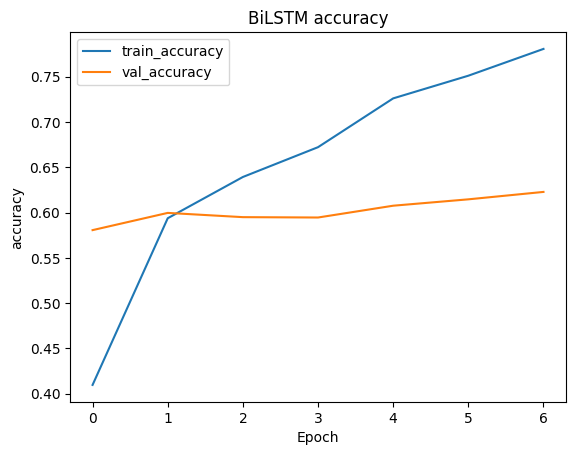

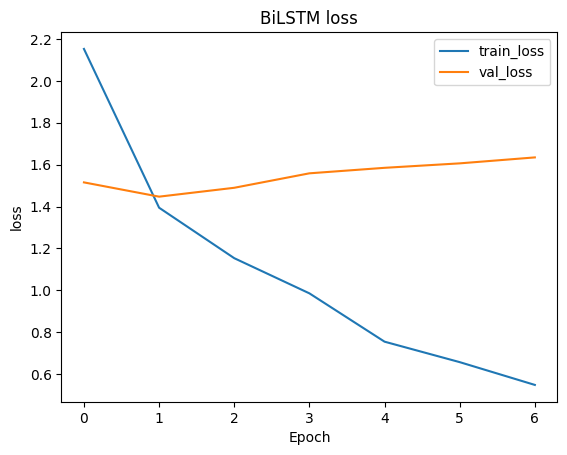

In [ ]:
# step 4: Curves

import matplotlib.pyplot as plt

def plot_history(history, key="accuracy", title_suffix=""):
    plt.figure()
    plt.plot(history.history[key], label=f"train_{key}")
    plt.plot(history.history[f"val_{key}"], label=f"val_{key}")
    plt.xlabel("Epoch"); plt.ylabel(key); plt.legend()
    plt.title(f"{title_suffix} {key}".strip())

plot_history(hist_custom, "accuracy", "BiLSTM")
plot_history(hist_custom, "loss", "BiLSTM")


In [ ]:
# step 5: Evaluation (same protocol as P2 for apples-to-apples)

from sklearn.metrics import classification_report, f1_score

test_loss_c, test_acc_c = custom.evaluate(ds_test, verbose=0)
print(f"[Custom BiLSTM] Test Loss: {test_loss_c:.4f} | Test Accuracy: {test_acc_c:.4f}")

y_true, y_pred = [], []
for xb, yb in ds_test:
    p = custom.predict(xb, verbose=0)
    y_true.extend(yb.numpy().tolist())
    y_pred.extend(np.argmax(p, axis=1).tolist())

macro_f1_c = f1_score(y_true, y_pred, average="macro")
print(f"[Custom BiLSTM] Macro F1 (test): {macro_f1_c:.4f}")

print(classification_report(
    y_true, y_pred, target_names=[id2cat[i] for i in range(NUM_CLASSES)], digits=3
))


[Custom BiLSTM] Test Loss: 1.4565 | Test Accuracy: 0.5946
[Custom BiLSTM] Macro F1 (test): 0.5133
                        precision    recall  f1-score   support

  ARTS & ENTERTAINMENT      0.743     0.562     0.640      1993
          BLACK VOICES      0.362     0.558     0.439       452
      BUSINESS & MONEY      0.560     0.467     0.510       764
                COMEDY      0.605     0.401     0.483       516
                 CRIME      0.317     0.703     0.437       340
             EDUCATION      0.320     0.642     0.427       215
           ENVIRONMENT      0.450     0.551     0.495       394
FAMILY & RELATIONSHIPS      0.809     0.640     0.714      1962
                 FIFTY      0.204     0.429     0.276       140
          FOOD & DRINK      0.773     0.744     0.758       832
             GOOD NEWS      0.186     0.371     0.248       140
     HEALTH & WELLNESS      0.828     0.517     0.636      2451
         HOME & LIVING      0.606     0.748     0.670       416
     

2025-11-10 15:48:21.248764: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


### Graded Questions (5 pts each)

1. **Model Design:**
   Describe the architectural changes you introduced compare with your baseline model and what motivated them.

3.1. **Your answer here:**


For our custom model, we extended the baseline in two meaningful ways.

First, we replaced the purely order-agnostic GlobalAveragePooling architecture with a Bidirectional LSTM to capture sequential structure and contextual dependencies that the baseline entirely ignores.

Second, we added regularization components—SpatialDropout1D, standard Dropout, and mild L2—to address the baseline’s strong overfitting behavior. We also increased the embedding dimensionality (from 64 → 128) to give the recurrent layer richer representations to work with.

The final architecture is:
Embedding → SpatialDropout1D → BiLSTM → GlobalMaxPooling → Dense(256, ReLU) → Dropout → Softmax.

We designed this model specifically to target the baseline’s limitations: lack of sequence modeling, limited expressive capacity, and immediate overfitting despite its simplicity.


2. **Training Results:**
   Present key validation and test metrics. Did your modifications improve performance?

3.2. **Your answer here:**

The custom model trained for 7 epochs before early stopping reduced the learning rate twice and halted.
Key metrics:

- Best validation accuracy: ~0.6227

- Test accuracy: 0.5946 (slight improvement from baseline 0.5794)

- Macro-F1: 0.5153 (slight improvement from baseline 0.4940)

Validation accuracy and macro-F1 both improved over the baseline, indicating that adding sequence modeling helped the model extract better semantic signals from short texts. Train accuracy climbed to ~77.5%, while validation stabilized around 55–60%, which is slightly higher than the baseline’s ~50–555%.

Overall, the modifications delivered a small but measurable generalization improvement.

3. **Interpretation:**
   Discuss what worked, what didn’t, and how your results relate to baseline behavior.

3.3. **Your answer here:**

The BiLSTM clearly helped: it improved both accuracy and macro-F1 across validation and test sets. This suggests that the model could capture better contextual relationships (e.g., word order and phrase patterns) that the baseline average-embedding model could not. Rare classes in particular showed better recall, reflected in the macro-F1 improvement.

However, the model still overfits, as shown by the widening gap between training and validation loss after epoch ~3. Even with dropout and a learning-rate schedule, the model’s capacity allows it to memorize patterns quickly. The validation loss curve also shows some instability, suggesting that class imbalance and noisy categories still pose challenges.

Compared to the baseline, the custom model generalizes better and converges faster during the initial epochs, but still exhibits the same underlying overfitting trend; only delayed rather than eliminated.

4. **Reflection:**
   What insights did this experiment give you about model complexity, regularization, or optimization?

3.4. **Your answer here:**

This experiment highlighted how adding model complexity (a BiLSTM) can meaningfully improve performance, but it also emphasized the importance of regularization and the diminishing returns of deeper models on short text. Even with dropout, SpatialDropout, and L2, the model began overfitting early, suggesting that further gains likely require either:

- pretrained contextual embeddings,

- more aggressive regularization, or

- architectures better suited for short text, such as CNNs or attention-based models.

We also learned that improvements in macro-F1 are harder to achieve than accuracy due to the dataset’s long-tail label distribution. The fact that F1 increased shows that the BiLSTM helped with harder, less frequent categories.

Overall, this experiment reinforces that while model depth can help, pretraining or a fundamentally richer representation (e.g., transformers) will likely be needed for substantial further improvements.



___

## Problem 4 – Pretrained Model (Transfer Learning) (20 pts)

### Goal

Apply **transfer learning** to see how pretrained knowledge improves accuracy, convergence speed, and generalization.
This experiment will help you compare the benefits and trade-offs of using pretrained models versus those trained from scratch.


### Steps to Follow

1. **Select a pretrained architecture**

   * **Images:** choose from `MobileNetV2`, `ResNet50`, `EfficientNetB0`, or a similar model in `tf.keras.applications`.
   * **Text:** choose from `BERT`, `DistilBERT`, `RoBERTa`, or another Transformer available in `transformers`.

2. **Adapt the model for your dataset**

   * Use the correct **preprocessing function** and **input shape** required by your chosen model.
   * Replace the top layer with your own **classification head** (e.g., `Dense(num_classes, activation='softmax')`).

3. **Apply transfer learning**

   * Choose an appropriate **training strategy** for your pretrained model. Options include:

     * **Freezing** the pretrained base and training only a new classification head.
     * **Partially fine-tuning** selected upper layers of the base model.
     * **Full fine-tuning** (all layers trainable) with a reduced learning rate.
   * Adjust your learning rate schedule to match your strategy (e.g., smaller LR for fine-tuning).
   * Observe how your chosen approach affects **validation loss**, **training time**, and **model stability**.

4. **Train and evaluate under consistent conditions**

   * Use the same **splits**, **metrics**, and **evaluation protocol** as in earlier problems.
   * Record training duration, validation/test performance, and any resource constraints (GPU memory, runtime).

5. **Compare and analyze**

   * Observe how transfer learning changes both **performance** and **efficiency** relative to your baseline and custom models.
   * Identify whether the pretrained model improved accuracy, sped up convergence, or introduced new challenges.


____

### **Distil-BERT + Custom Head**

Build Model

In [ ]:
import numpy as np

X_train_bert = np.asarray(X_train).astype("U")   # strings
X_val_bert   = np.asarray(X_val).astype("U")
X_test_bert  = np.asarray(X_test).astype("U")

y_train_bert = np.asarray(y_train).astype("int32")
y_val_bert   = np.asarray(y_val).astype("int32")
y_test_bert  = np.asarray(y_test).astype("int32")

In [ ]:
import keras_hub as kh
from tensorflow import keras
from tensorflow.keras import layers

NUM_CLASSES = len(cats)
MAX_LEN     = MAX_LENGTH


preproc  = kh.models.DistilBertTextClassifierPreprocessor.from_preset(
    "distil_bert_base_en_uncased", sequence_length=MAX_LEN
)
pipeline = kh.models.DistilBertTextClassifier.from_preset(
    "distil_bert_base_en_uncased", num_classes=NUM_CLASSES, preprocessor=preproc
)

text_in  = keras.Input(shape=(), dtype="string", name="text")
tokens   = preproc(text_in)                                 # {'token_ids','padding_mask'}

backbone = pipeline.get_layer("distil_bert_backbone")       # reuse weights
backbone.trainable = True                                   # make backbone trainable 

seq_out  = backbone(tokens)                                 # (B, T, 768)


# Custom Head
cls      = layers.Lambda(lambda t: t[:, 0, :], name="cls")(seq_out)
x        = layers.Dense(256, activation="relu")(cls)
x        = layers.Dropout(0.3)(x)
logits   = layers.Dense(NUM_CLASSES, activation="softmax")(x)

bertinator = keras.Model(text_in, logits, name="distilbert_strin_custom")

bertinator.summary()

Model: "distilbert_strin_custom"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ text (InputLayer)   │ (None)            │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ distil_bert_text_c… │ [(None, 56),      │          0 │ text[0][0]        │
│ (DistilBertTextCla… │ (None, 56)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ distil_bert_backbo… │ (None, 56, 768)   │ 66,362,880 │ distil_bert_text… │
│ (DistilBertBackbon… │                   │            │ distil_bert_text… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cls (Lambda)        │ (None, 768)       │          0 │ distil_bert_back… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_34 (Dense)    │ (None, 256)       │    196,864 │ cls[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_143         │ (None, 256)       │          0 │ dense_34[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_35 (Dense)    │ (None, 28)        │      7,196 │ dropout_143[0][0] │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 66,566,940 (253.93 MB)

 Trainable params: 66,566,940 (253.93 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
import tensorflow as tf
AUTOTUNE = tf.data.AUTOTUNE
BATCH_BERT = 32


def make_ds_bert(X, y, shuffle=False):
    ds = tf.data.Dataset.from_tensor_slices((X, y))
    if shuffle:
        ds = ds.shuffle(10_000, seed=SEED, reshuffle_each_iteration=True)
    ds = ds.batch(BATCH_BERT, drop_remainder=False)
    # Match the model input name: "text"
    ds = ds.map(lambda x, y: ({"text": x}, y), num_parallel_calls=AUTOTUNE)
    return ds.prefetch(AUTOTUNE)

ds_train_bert = make_ds_bert(X_train, y_train, shuffle=True)
ds_val_bert   = make_ds_bert(X_val,   y_val,   shuffle=False)


# sanity Check
for xb, yb in ds_train_bert.take(1):
    print(xb.keys())          # should be: dict_keys(['text'])
    print(xb["text"].shape)   # (batch_size,)
    print(xb["text"].dtype)   # string
    print(yb.shape, yb.dtype) # (batch_size,), int32

dict_keys(['text'])
(32,)
<dtype: 'string'>
(32,) <dtype: 'int64'>


Step 2: Compile

In [ ]:
bertinator.compile(
    optimizer=keras.optimizers.Adam(1e-5),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=[keras.metrics.SparseCategoricalAccuracy(name="accuracy")],
    jit_compile=False
)

In [ ]:
import time
from tensorflow import keras

EPOCHS = 6

cb = [keras.callbacks.EarlyStopping(monitor="val_loss", patience=2, restore_best_weights=True)]


history = bertinator.fit(
    ds_train_bert,
    validation_data=ds_val_bert,
    epochs=EPOCHS,
    class_weight=CLASS_WEIGHTS,
    callbacks=cb,
    verbose=2,
)

print(f"Elapsed Time: {(time.time()-start)/60:.2f} min")

Epoch 1/6
5009/5009 - 264s - 53ms/step - accuracy: 0.5461 - loss: 1.6139 - val_accuracy: 0.6389 - val_loss: 1.2692
Epoch 2/6
5009/5009 - 241s - 48ms/step - accuracy: 0.6503 - loss: 1.1497 - val_accuracy: 0.6579 - val_loss: 1.1934
Epoch 3/6
5009/5009 - 241s - 48ms/step - accuracy: 0.6853 - loss: 0.9682 - val_accuracy: 0.6761 - val_loss: 1.1177
Epoch 4/6
5009/5009 - 245s - 49ms/step - accuracy: 0.7191 - loss: 0.8093 - val_accuracy: 0.6878 - val_loss: 1.1072
Epoch 5/6
5009/5009 - 247s - 49ms/step - accuracy: 0.7471 - loss: 0.6774 - val_accuracy: 0.6883 - val_loss: 1.1247
Epoch 6/6
5009/5009 - 247s - 49ms/step - accuracy: 0.7715 - loss: 0.5687 - val_accuracy: 0.6893 - val_loss: 1.1363
Elapsed Time: 149.65 min


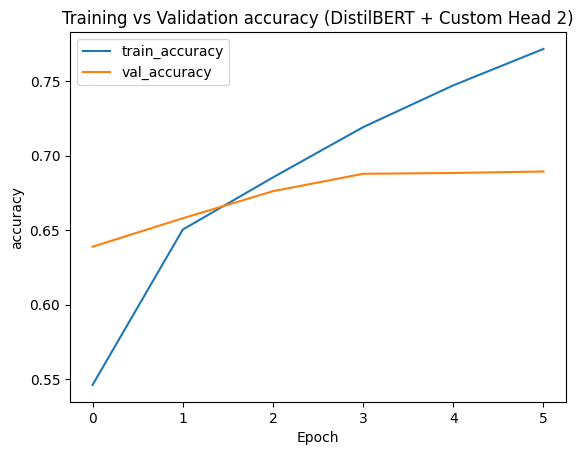

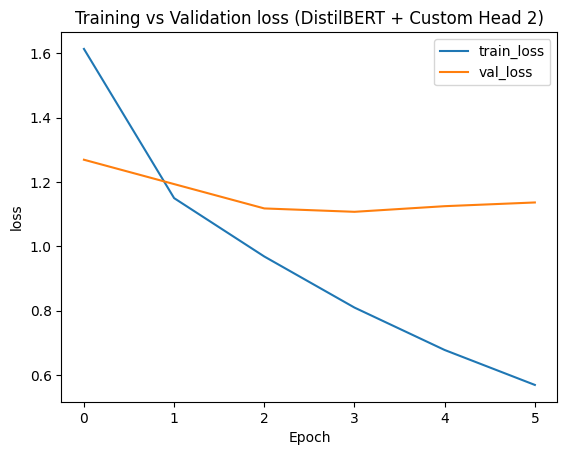

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, classification_report

def plot_history(history, key="acc", title_suffix=""):
    # Works for either 'acc'/'accuracy' depending on metric name
    # Try common keys
    train_key = next((k for k in history.history.keys() if k in (key, f"train_{key}", "acc", "accuracy")), None)
    val_key   = next((k for k in history.history.keys() if k in (f"val_{key}", "val_acc", "val_accuracy")), None)
    assert train_key and val_key, f"Keys not found in history: {list(history.history.keys())}"
    plt.figure()
    plt.plot(history.history[train_key], label=f"train_{key}")
    plt.plot(history.history[val_key],   label=f"val_{key}")
    plt.xlabel("Epoch"); plt.ylabel(key); plt.title(f"Training vs Validation {key} {title_suffix}".strip())
    plt.legend(); plt.show()


def plot_history_loss(history, title_suffix=""):
    plt.figure()
    plt.plot(history.history["loss"], label="train_loss")
    plt.plot(history.history["val_loss"], label="val_loss")
    plt.xlabel("Epoch"); plt.ylabel("loss"); plt.title(f"Training vs Validation loss {title_suffix}".strip())
    plt.legend(); plt.show()


plot_history(history, key="accuracy", title_suffix="(DistilBERT + Custom Head 2)")
plot_history_loss(history, title_suffix="(DistilBERT + Custom Head 2)")

In [ ]:
model =  bertinator # or distil, or bert_custom, etc.

EVAL_BATCH = 64

logits_or_probs = model.predict(
    {"text": X_test},
    batch_size=EVAL_BATCH,
    verbose=0
)

y_pred = np.argmax(logits_or_probs, axis=-1)

y_true = np.asarray(y_test)
test_acc = accuracy_score(y_true, y_pred)
macro_f1 = f1_score(y_true, y_pred, average="macro")

print(f"\n[Test] Accuracy: {test_acc:.4f} | Macro F1: {macro_f1:.4f}\n")
print(classification_report(
    y_true, y_pred,
    target_names=[id2cat[i] for i in range(NUM_CLASSES)],
    digits=3
))


[Test] Accuracy: 0.6884 | Macro F1: 0.6148

                        precision    recall  f1-score   support

  ARTS & ENTERTAINMENT      0.820     0.618     0.704      1993
          BLACK VOICES      0.444     0.637     0.524       452
      BUSINESS & MONEY      0.612     0.657     0.634       764
                COMEDY      0.523     0.583     0.552       516
                 CRIME      0.536     0.729     0.618       340
             EDUCATION      0.374     0.767     0.503       215
           ENVIRONMENT      0.575     0.701     0.632       394
FAMILY & RELATIONSHIPS      0.852     0.765     0.806      1962
                 FIFTY      0.246     0.586     0.346       140
          FOOD & DRINK      0.834     0.843     0.838       832
             GOOD NEWS      0.287     0.414     0.339       140
     HEALTH & WELLNESS      0.865     0.678     0.761      2451
         HOME & LIVING      0.720     0.839     0.775       416
                IMPACT      0.290     0.538     0.377     

### **Additional Exploration: Bert (Base)**

In [ ]:
import keras_hub as kh
from tensorflow import keras
from tensorflow.keras import layers

NUM_CLASSES = len(cats)
MAX_LEN     = MAX_LENGTH

bert_preproc = kh.models.BertTextClassifierPreprocessor.from_preset(
    "bert_base_en_uncased",
    sequence_length=MAX_LEN,
)

bert_pipeline = kh.models.BertTextClassifier.from_preset(
    "bert_base_en_uncased",
    num_classes=NUM_CLASSES,
    preprocessor=bert_preproc,
)

text_in  = keras.Input(shape=(), dtype="string", name="text")
tokens   = bert_preproc(text_in)

bert_backbone = bert_pipeline.get_layer("bert_backbone")

# backbone outputs a dict with 'sequence_output' and 'pooled_output'
bert_outputs = bert_backbone(tokens)

pooled = bert_outputs["pooled_output"]          # shape: (batch, 768)

x      = layers.Dense(256, activation="relu", name="head_dense")(pooled)
x      = layers.Dropout(0.3, name="head_dropout")(x)
logits = layers.Dense(NUM_CLASSES, activation="softmax", name="logits")(x)

bert_big = keras.Model(text_in, logits, name="bert_base_strin_custom")

bert_big.summary()

100%|██████████| 457/457 [00:00<00:00, 970kB/s]


100%|██████████| 761/761 [00:00<00:00, 2.00MB/s]


100%|██████████| 226k/226k [00:00<00:00, 2.13MB/s]


100%|██████████| 418M/418M [00:04<00:00, 103MB/s]


Model: "bert_base_strin_custom"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ text (InputLayer)   │ (None)            │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bert_text_classifi… │ [(None, 56),      │          0 │ text[0][0]        │
│ (BertTextClassifie… │ (None, 56),       │            │                   │
│                     │ (None, 56)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bert_backbone       │ [(None, 768),     │ 109,482,2… │ bert_text_classi… │
│ (BertBackbone)      │ (None, 56, 768)]  │            │ bert_text_classi… │
│                     │                   │            │ bert_text_classi… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ head_dense (Dense)  │ (None, 256)       │    196,864 │ bert_backbone[1]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ head_dropout        │ (None, 256)       │          0 │ head_dense[0][0]  │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ logits (Dense)      │ (None, 28)        │      7,196 │ head_dropout[0][… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 109,686,300 (418.42 MB)

 Trainable params: 109,686,300 (418.42 MB)

 Non-trainable params: 0 (0.00 B)

Step 2: Compile

In [ ]:
bert_big.compile(
    optimizer=keras.optimizers.Adam(2e-5),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=[keras.metrics.SparseCategoricalAccuracy(name="accuracy")],
    jit_compile=False,      # avoid XLA issues with string ops
)

Train

In [ ]:
import time
from tensorflow import keras as tf_keras

EPOCHS_BERT = 4
BATCH_BERT  = 16  # smaller than Distil's 32 to fit in memory

cb_bert = [
    keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=2,
        restore_best_weights=True
    ),
]

start = time.time()
history_bert = bert_big.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS_BERT,
    batch_size=BATCH_BERT,
    class_weight=CLASS_WEIGHTS,
    callbacks=cb_bert,
    verbose=2,
)
print(f"Elapsed Time (BERT base): {(time.time()-start)/60:.2f} min")

Epoch 1/4
10018/10018 - 762s - 76ms/step - accuracy: 0.5970 - loss: 1.4314 - val_accuracy: 0.6728 - val_loss: 1.1179
Epoch 2/4
10018/10018 - 717s - 72ms/step - accuracy: 0.7047 - loss: 0.9203 - val_accuracy: 0.6920 - val_loss: 1.0431
Epoch 3/4
10018/10018 - 718s - 72ms/step - accuracy: 0.7660 - loss: 0.6303 - val_accuracy: 0.6820 - val_loss: 1.1318
Epoch 4/4
10018/10018 - 718s - 72ms/step - accuracy: 0.8122 - loss: 0.4451 - val_accuracy: 0.7108 - val_loss: 1.1124
Elapsed Time (BERT base): 48.59 min


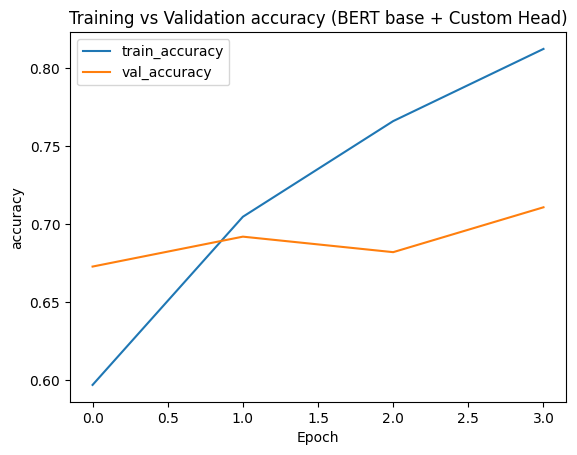

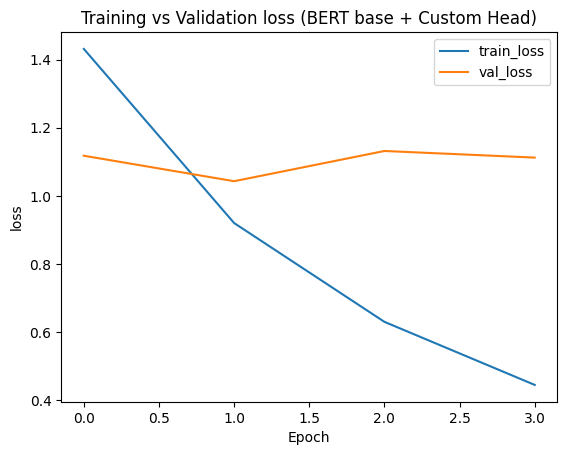

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, classification_report

def plot_history(history, key="acc", title_suffix=""):
    # Works for either 'acc'/'accuracy' depending on metric name
    # Try common keys
    train_key = next((k for k in history.history.keys() if k in (key, f"train_{key}", "acc", "accuracy")), None)
    val_key   = next((k for k in history.history.keys() if k in (f"val_{key}", "val_acc", "val_accuracy")), None)
    assert train_key and val_key, f"Keys not found in history: {list(history.history.keys())}"
    plt.figure()
    plt.plot(history.history[train_key], label=f"train_{key}")
    plt.plot(history.history[val_key],   label=f"val_{key}")
    plt.xlabel("Epoch"); plt.ylabel(key); plt.title(f"Training vs Validation {key} {title_suffix}".strip())
    plt.legend(); plt.show()


def plot_history_loss(history, title_suffix=""):
    plt.figure()
    plt.plot(history.history["loss"], label="train_loss")
    plt.plot(history.history["val_loss"], label="val_loss")
    plt.xlabel("Epoch"); plt.ylabel("loss"); plt.title(f"Training vs Validation loss {title_suffix}".strip())
    plt.legend(); plt.show()


plot_history(history_bert, key="accuracy", title_suffix="(BERT base + Custom Head)")
plot_history_loss(history_bert, title_suffix="(BERT base + Custom Head)")

In [ ]:
EVAL_BATCH = 64  # or 32; whatever you’ve been using

logits_or_probs_bert = bert_big.predict(
    {"text": X_test},
    batch_size=EVAL_BATCH,
    verbose=0,
)
y_pred_bert = np.argmax(logits_or_probs_bert, axis=-1)

y_true = np.asarray(y_test)
test_acc_bert = accuracy_score(y_true, y_pred_bert)
macro_f1_bert = f1_score(y_true, y_pred_bert, average="macro")

print(f"\n[BERT base] Test Accuracy: {test_acc_bert:.4f} | Macro F1: {macro_f1_bert:.4f}\n")
print(classification_report(
    y_true, y_pred_bert,
    target_names=[id2cat[i] for i in range(NUM_CLASSES)],
    digits=3
))

/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: text
Received: inputs=['Tensor(shape=(64,))']
  warnings.warn(msg)
/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: text
Received: inputs=['Tensor(shape=(None,))']
  warnings.warn(msg)



[BERT base] Test Accuracy: 0.6893 | Macro F1: 0.6123

                        precision    recall  f1-score   support

  ARTS & ENTERTAINMENT      0.840     0.612     0.708      1993
          BLACK VOICES      0.466     0.657     0.545       452
      BUSINESS & MONEY      0.612     0.639     0.625       764
                COMEDY      0.487     0.599     0.537       516
                 CRIME      0.579     0.715     0.639       340
             EDUCATION      0.459     0.735     0.565       215
           ENVIRONMENT      0.548     0.683     0.608       394
FAMILY & RELATIONSHIPS      0.871     0.756     0.809      1962
                 FIFTY      0.283     0.636     0.392       140
          FOOD & DRINK      0.846     0.852     0.849       832
             GOOD NEWS      0.247     0.471     0.324       140
     HEALTH & WELLNESS      0.877     0.646     0.744      2451
         HOME & LIVING      0.710     0.829     0.765       416
                IMPACT      0.420     0.355     

In [13]:
final_df.groupby(by='Model')[['Test_Accuracy', 'F1']].mean()

,Test_Accuracy,F1
Model,,
Run 1 - Baseline,0.5794,0.497533
Run 2 - Custom BiLSTM,0.5946,0.516600
Run 3 - DistilBERT + Custom Head,0.6856,0.614067
Run 4 - BERTBase,0.6893,0.615333


### Graded Questions (5 pts each)

1. **Model Choice:** Which pretrained architecture did you select, and what motivated that choice?

4.1. **Your answer here:**

We actually experimented with two pre-trained transformer architectures: DistilBERT and BERT Base. 

DistilBERT was initially selected because of its smaller size and lower computational cost, which was deemed more practical to train in a Colab environment.  Despite the reduced parameter count, however, training still remained computationally expensive, with training still requiring around 30 minutes on average per run.  That being said, DistilBERT consistently offered the best trade off between performance. 

Bert Base was investigated later as an exploratory move to see if more performance could be gained from the addition of additional parameters. These performance gains were minimal, however, and DistilBERT with our fine tuning still outperformed the larger model in many class recall tasks. 

For the custom classification head subsequent to the model, we used an unfrozen backbone in the DistilBERT model, with a dense layer of 256 neurons and a 0.3 dropout baseline. This was deemed sufficient for a baseline tuning task as the prompt mentioned that further model tuning would take place in the weeks to come, as will be explained in section 4.2.



2. **Fine-Tuning Plan:** Describe your fine-tuning strategy and why you chose it.

4.2. **Your answer here:**

Our fine tuning strategy consisted of unfreezing the DistilBERT backbone, and attaching a dense 256-neuron classification head with a ReLU activation and a 0.3 dropout layer. This structure was chosen because prior experiments showed that unlocking the backbone consistently produced modest performance gains, whereas widening the classification head (to 1024 neurons for example) did not yield additional benefit. 

Dropout was included to help curb overfitting which we observed in both the baseline and BiLSTM models in this milestone, and again in initial DistilBERT testing. This paired with the 256 unit classification head served as an effective baseline architecture for this project. 

Looking forward, additional fine-tuning opportunities include adding more dense layers in a deeper head configuration (512 -> 256 -> 128, etc.); selectively unfreezing transformer layers; tesing different learning rates; experimenting with weight decay; and adding additional dropout. Another avanue for refinement would be re-evaluating class consolidation useing Jaccard similarity or correlation based grouping to ensure the classifier is operating on well defined and semantically distinct categories. 

3. **Performance:** Report key metrics and compare them with your baseline and custom models.

4.3. **Your answer here:**

Across all of our experiments, both overall accuracy and Macro F1 scores received a ~10-12% bump in performance relative to our baseline models:

F1 Accuracy:
- Run 1 Baseline               0.4975
- Run 2 Custom BiLSTM          0.5167
- Run 3 DistBERT + Custom Head 0.6141
- Run 4 BERT (Base)            0.6893

Model Accuracy: 
- Run 1 Baseline               0.5794
- Run 2 Custom BiLSTM          0.5946
- Run 3 DistBert+ Custom Head  0.6856
- Run 4 Bert (Base)            0.6153


The transformer model not only improved in overall metrics, but also showed strong gains in category level recall, especially for high support classes where recall commonly reached 70-80%. This represents a meaningful improvement in performance (As will be discussed more in section 5). 

Whle some minority classes continue to show lower recall across all of the models (consistent with the imbalanced dataset), the transformer provides a robust starting point for additional fine-tuning in the final milestone. 

4. **Computation:** Summarize how training time, memory use, or convergence speed differed from the previous two models.

4.4. **Your answer here:**

While the convergence speed of the BERT models were definitely much improved over the baseline and custom models (Yielding adequate convergence in 4-6 epochs rather than the 7 epochs with the custom model (early stopping) and 26 epochs for the baseline.)

While this was a significant improvement the time to train per epoch was massively increased from 0.052 minutes per epoch for the base model to 12.14 minutes per epoch to train the BERT Base model. Here is a summary of the results of each Model run on A100's in Colab: 


| Model                | Parameters     | Run Time (A100) |Epochs    | Time per Epoch (A100)  | 
|----------------------|----------------|---------------|------------| -----------------------|
| Model 1 - Baseline   | 1,931,932      |  1.35 minutes  | 26        |     0.052 m / e        | 
| Model 2 - BiLSTM     | 4,176,156      | 1.78  minutes |  7         |     0.25 m / e         | 
| Model 3 - DistilBERT | 66,566,940     | 39.35 minutes| 6           |     6.55 m / e         | 
| Model 4 - BertBASE   | 109,686,300    | 48.59 minutes | 4          |     12.14 m / e       | 

While memory use was not measured per se, as the later models were trained on Collab, the number of parameters per model was as follows: 

- Model 1:   1, 931, 932 params
- Model 2:   4, 176, 156 params
- Model 3:  66, 566, 940 params
- Model 4: 109, 686, 300 params



## Problem 5 – Comparative Evaluation and Discussion (20 pts)

### Goal

Compare your **baseline**, **custom**, and **pretrained** models to evaluate how design choices affected performance, efficiency, and generalization.
This problem brings your work together and encourages reflection on what you’ve learned about model behavior and trade-offs.

**Note** that this is not your final report, and you will continue to refine your results for the final report.

### Steps to Follow

1. **Compile key results**

   * Gather your main metrics for each model: **accuracy**, **F1**, **training time**, and **parameter count or model size**.
   * Ensure all numbers come from the same evaluation protocol and test set.

2. **Visualize the comparison**

   * Present results in a **single, well-organized chart or table**.
   * Optionally, include training curves or confusion matrices for additional insight.

3. **Analyze comparative performance**

   * Observe which model performed best by your chosen metric(s).
   * Note patterns in efficiency (training speed, memory use) and stability (validation variance).

4. **Inspect model behavior**

   * Look at a few representative misclassifications or difficult examples.
   * Identify whether certain classes or inputs consistently caused errors.

5. **Plan forward improvements**

   * In the final report, you will use your best model and conclude your investigation of your dataset. Based on your observations, decide on a model and next steps for refining your approach in the final project (e.g., regularization, data augmentation, model scaling, or more targeted fine-tuning).

#### **Results Dump and Setup**

In [ ]:
# Take print outs from each of the model runs and construct a DataFrame from the results
# Developed with help from ChatGPT: https://chatgpt.com/share/6917bf86-dc98-800f-9ef1-4d43fefb8861

import pandas as pd
import re


raw_text = """

Run 1: Baseline Results
Test Loss: 1.6212 | Test Accuracy: 0.5794
Macro F1 (test): 0.4940
                        precision    recall  f1-score   support

  ARTS & ENTERTAINMENT      0.645     0.590     0.616      1993
          BLACK VOICES      0.316     0.555     0.403       452
      BUSINESS & MONEY      0.423     0.588     0.492       764
                COMEDY      0.376     0.490     0.426       516
                 CRIME      0.475     0.553     0.511       340
             EDUCATION      0.292     0.600     0.393       215
           ENVIRONMENT      0.431     0.485     0.456       394
FAMILY & RELATIONSHIPS      0.784     0.593     0.676      1962
                 FIFTY      0.149     0.307     0.200       140
          FOOD & DRINK      0.683     0.767     0.723       832
             GOOD NEWS      0.186     0.279     0.223       140
     HEALTH & WELLNESS      0.804     0.563     0.662      2451
         HOME & LIVING      0.600     0.745     0.665       416
                IMPACT      0.317     0.318     0.317       346
         LATINO VOICES      0.246     0.451     0.319       113
                 MEDIA      0.288     0.609     0.391       281
              POLITICS      0.875     0.531     0.661      3272
          QUEER VOICES      0.542     0.732     0.623       631
              RELIGION      0.453     0.494     0.473       255
               SCIENCE      0.379     0.596     0.463       218
                SPORTS      0.668     0.642     0.655       489
                 STYLE      0.241     0.612     0.346       224
        STYLE & BEAUTY      0.784     0.730     0.756       951
                  TECH      0.397     0.473     0.431       203
                TRAVEL      0.751     0.657     0.701       989
            WEIRD NEWS      0.284     0.408     0.335       267
                 WOMEN      0.240     0.368     0.290       340
            WORLD NEWS      0.686     0.577     0.627       842

              accuracy                          0.579     20036
             macro avg      0.476     0.547     0.494     20036
          weighted avg      0.650     0.579     0.598     20036

          
Run 2: Custom BiLSTM
 ━━━━━━━━━━━━━━━━━━━━ 173s 138ms/step - accuracy: 0.7806 - loss: 0.5487 - val_accuracy: 0.6227 - val_loss: 1.6345 - learning_rate: 5.0000e-04
Training runtime: 19.81 minutes | epochs: 7
[Custom BiLSTM] Test Loss: 1.4565 | Test Accuracy: 0.5946
[Custom BiLSTM] Macro F1 (test): 0.5133
                        precision    recall  f1-score   support

  ARTS & ENTERTAINMENT      0.743     0.562     0.640      1993
          BLACK VOICES      0.362     0.558     0.439       452
      BUSINESS & MONEY      0.560     0.467     0.510       764
                COMEDY      0.605     0.401     0.483       516
                 CRIME      0.317     0.703     0.437       340
             EDUCATION      0.320     0.642     0.427       215
           ENVIRONMENT      0.450     0.551     0.495       394
FAMILY & RELATIONSHIPS      0.809     0.640     0.714      1962
                 FIFTY      0.204     0.429     0.276       140
          FOOD & DRINK      0.773     0.744     0.758       832
             GOOD NEWS      0.186     0.371     0.248       140
     HEALTH & WELLNESS      0.828     0.517     0.636      2451
         HOME & LIVING      0.606     0.748     0.670       416
                IMPACT      0.183     0.422     0.255       346
         LATINO VOICES      0.236     0.602     0.339       113
                 MEDIA      0.354     0.612     0.449       281
              POLITICS      0.888     0.557     0.684      3272
          QUEER VOICES      0.723     0.704     0.713       631
              RELIGION      0.373     0.659     0.476       255
               SCIENCE      0.355     0.606     0.447       218
                SPORTS      0.623     0.710     0.663       489
                 STYLE      0.338     0.647     0.444       224
        STYLE & BEAUTY      0.772     0.803     0.787       951
                  TECH      0.266     0.670     0.380       203
                TRAVEL      0.732     0.714     0.723       989
            WEIRD NEWS      0.270     0.393     0.320       267
                 WOMEN      0.273     0.388     0.321       340
            WORLD NEWS      0.638     0.632     0.635       842

              accuracy                          0.595     20036
             macro avg      0.492     0.587     0.513     20036
          weighted avg      0.680     0.595     0.616     20036


Run 3: DistillBERT + Custom Head
 [Distill BERT] Accuracy: 0.6856 | Macro F1: 0.6112

                        precision    recall  f1-score   support

  ARTS & ENTERTAINMENT      0.830     0.629     0.715      1993
          BLACK VOICES      0.445     0.681     0.538       452
      BUSINESS & MONEY      0.610     0.654     0.631       764
                COMEDY      0.480     0.597     0.532       516
                 CRIME      0.498     0.726     0.591       340
             EDUCATION      0.403     0.740     0.521       215
           ENVIRONMENT      0.581     0.635     0.607       394
FAMILY & RELATIONSHIPS      0.855     0.739     0.793      1962
                 FIFTY      0.234     0.607     0.338       140
          FOOD & DRINK      0.838     0.845     0.841       832
             GOOD NEWS      0.281     0.507     0.361       140
     HEALTH & WELLNESS      0.875     0.650     0.745      2451
         HOME & LIVING      0.719     0.849     0.778       416
                IMPACT      0.281     0.549     0.372       346
         LATINO VOICES      0.314     0.805     0.452       113
                 MEDIA      0.416     0.712     0.525       281
              POLITICS      0.933     0.592     0.724      3272
          QUEER VOICES      0.744     0.748     0.746       631
              RELIGION      0.489     0.718     0.582       255
               SCIENCE      0.538     0.688     0.604       218
                SPORTS      0.710     0.785     0.746       489
                 STYLE      0.475     0.670     0.556       224
        STYLE & BEAUTY      0.868     0.853     0.860       951
                  TECH      0.466     0.670     0.549       203
                TRAVEL      0.840     0.841     0.841       989
            WEIRD NEWS      0.474     0.378     0.421       267
                 WOMEN      0.312     0.597     0.410       340
            WORLD NEWS      0.729     0.734     0.731       842

              accuracy                          0.686     20036
             macro avg      0.580     0.686     0.611     20036
          weighted avg      0.749     0.686     0.701     20036


          
Run 4: BERT Base
 [BERT base] Test Accuracy: 0.6893 | Macro F1: 0.6123

                        precision    recall  f1-score   support

  ARTS & ENTERTAINMENT      0.840     0.612     0.708      1993
          BLACK VOICES      0.466     0.657     0.545       452
      BUSINESS & MONEY      0.612     0.639     0.625       764
                COMEDY      0.487     0.599     0.537       516
                 CRIME      0.579     0.715     0.639       340
             EDUCATION      0.459     0.735     0.565       215
           ENVIRONMENT      0.548     0.683     0.608       394
FAMILY & RELATIONSHIPS      0.871     0.756     0.809      1962
                 FIFTY      0.283     0.636     0.392       140
          FOOD & DRINK      0.846     0.852     0.849       832
             GOOD NEWS      0.247     0.471     0.324       140
     HEALTH & WELLNESS      0.877     0.646     0.744      2451
         HOME & LIVING      0.710     0.829     0.765       416
                IMPACT      0.420     0.355     0.385       346
         LATINO VOICES      0.374     0.673     0.481       113
                 MEDIA      0.438     0.701     0.539       281
              POLITICS      0.916     0.623     0.742      3272
          QUEER VOICES      0.755     0.727     0.741       631
              RELIGION      0.449     0.710     0.550       255
               SCIENCE      0.364     0.784     0.497       218
                SPORTS      0.757     0.753     0.755       489
                 STYLE      0.382     0.763     0.509       224
        STYLE & BEAUTY      0.913     0.770     0.835       951
                  TECH      0.443     0.690     0.539       203
                TRAVEL      0.788     0.867     0.825       989
            WEIRD NEWS      0.438     0.577     0.498       267
                 WOMEN      0.302     0.629     0.408       340
            WORLD NEWS      0.675     0.795     0.730       842

              accuracy                          0.689     20036
             macro avg      0.580     0.687     0.612     20036
          weighted avg      0.749     0.689     0.704     20036
         
"""

# -------------------------------------------------
# Function to parse one run
# -------------------------------------------------
def parse_run(text):
    # Identify model/run name
    name_match = re.search(r'Run\s*\d+.*?:', text)
    model_name = name_match.group(0).replace(':', '').strip() if name_match else "Unknown"

    # Find accuracy and macro F1
    acc = re.search(r'Accuracy[:=]\s*([\d.]+)', text)
    macro_f1 = re.search(r'Macro F1.*?:\s*([\d.]+)', text)
    acc_val = float(acc.group(1)) if acc else None
    f1_val = float(macro_f1.group(1)) if macro_f1 else None

    rows = []
    capture = False
    for line in text.splitlines():
        line = line.strip()
        if not line:
            continue
        if line.startswith("precision"):
            capture = True
            continue
        if capture:
            # Match standard class or summary lines
            parts = re.split(r'\s{2,}', line)
            if len(parts) >= 2:
                try:
                    cls = parts[0].strip()
                    nums = re.findall(r'[\d.]+', line)
                    if len(nums) >= 4:
                        p, r, f, s = map(float, nums[:4])
                        row_type = "summary" if cls in ["accuracy", "macro avg", "weighted avg"] else "class"
                        rows.append({
                            "Model": model_name,
                            "Class": cls,
                            "Type": row_type,
                            "Precision": p,
                            "Recall": r,
                            "F1": f,
                            "Support": s,
                            "Test_Accuracy": acc_val,
                            "Macro_F1_overall": f1_val,
                        })
                except:
                    pass
    return pd.DataFrame(rows)

# Split the text into chunks and parse each run
runs = re.split(r'\n(?=Run\s*\d)', raw_text)
dfs = [parse_run(chunk) for chunk in runs if "precision" in chunk]

final_df = pd.concat(dfs, ignore_index=True)


In [6]:
# Renaming all of the Model Runs to better visualize results

final_df['Model'] = final_df['Model'].replace({
    'Run 1': 'Run 1 - Baseline',
    'Run 2': 'Run 2 - Custom BiLSTM', 
    'Run 3': 'Run 3 - DistilBERT + Custom Head',
    'Run 4': 'Run 4 - BERTBase'
}
)

In [10]:
# Constructing a Pivot Table to Organize Class Recall 
pivot_df = final_df[final_df['Type'].str.contains('class')].pivot_table(
    index='Class',
    columns='Model',
    values='Recall'
)
pivot_df

Model,Run 1 - Baseline,Run 2 - Custom BiLSTM,Run 3 - DistilBERT + Custom Head,Run 4 - BERTBase
Class,,,,
ARTS & ENTERTAINMENT,0.590,0.562,0.629,0.612
BLACK VOICES,0.555,0.558,0.681,0.657
BUSINESS & MONEY,0.588,0.467,0.654,0.639
COMEDY,0.490,0.401,0.597,0.599
CRIME,0.553,0.703,0.726,0.715
EDUCATION,0.600,0.642,0.740,0.735
ENVIRONMENT,0.485,0.551,0.635,0.683
FAMILY & RELATIONSHIPS,0.593,0.640,0.739,0.756
FIFTY,0.307,0.429,0.607,0.636


In [9]:
# Construct a summart table to be used in Part 5 with Accuracy and Macro F1
summary_table = (
    final_df
    .groupby("Model")[["Test_Accuracy", "F1"]]
    .mean()
    .round(4)
)

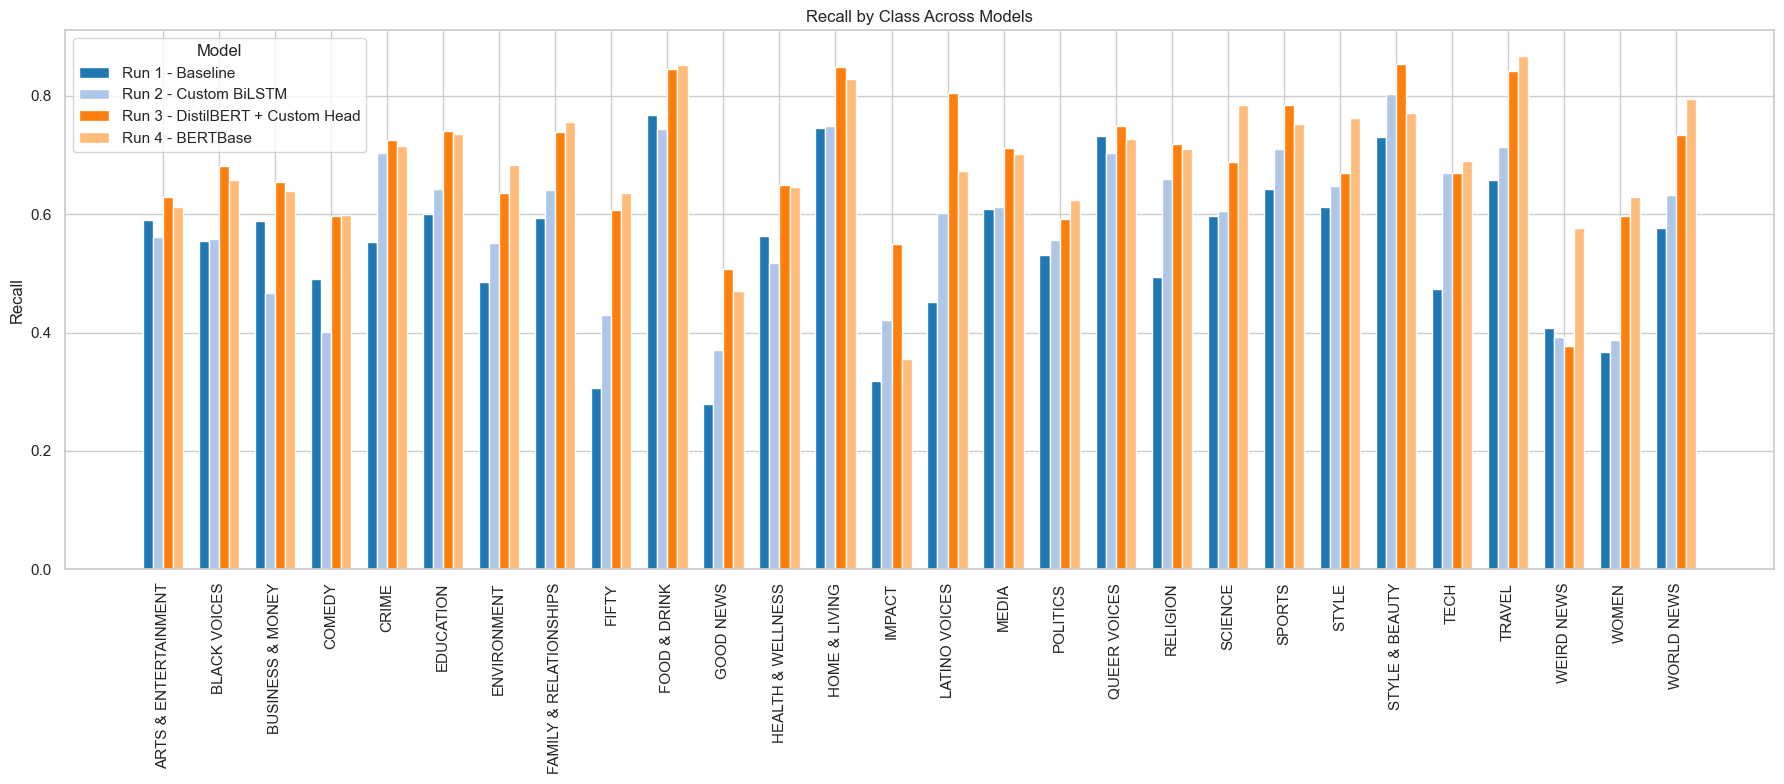

In [11]:
# And finally, create a grouped bar chart to visualize Class Recall differences between the different models

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

sns.set_theme(style="whitegrid")

n_models = len(pivot_df.columns)
colors = sns.color_palette("tab20", n_colors=n_models)

classes = pivot_df.index
models  = pivot_df.columns

x = np.arange(len(classes))
width = 0.18

fig, ax = plt.subplots(figsize=(18, 8))   # <--- CREATE FIG + AX

for i, model in enumerate(models):
    ax.bar(
        x + i*width,
        pivot_df[model].values,
        width,
        color=colors[i],
        label=model
    )

ax.set_xticks(x + width*(n_models-1)/2)
ax.set_xticklabels(classes, rotation=90)
ax.set_ylabel("Recall")
ax.set_title("Recall by Class Across Models")
ax.legend(title="Model")

fig.tight_layout()

class_recall_comparison = fig   

### Graded Questions (4 pts each)

1. **Summary Table and Performance Analysis:** Present a clear quantitative comparison of all three models. Which model achieved the best overall results, and what factors contributed to its success?

5.1. **Your answer here:**



When it comes to overall performance, both of the pre-trained models modestly outperformed the baseline and Custom BiLSTM models, with both BERT models achieving nearly identical overall metrics (BERT base only improved over DistilBERT by ~0.3 percentage points, which easily falls into the margin of error when run-to-run variance is considered). The summary table of these overall metrics is as follows: 

In [136]:
summary_table

,Test_Accuracy,F1
Model,,
Run 1 - Baseline,0.5794,0.4975
Run 2 - Custom BiLSTM,0.5946,0.5166
Run 3 - DistilBERT + Custom Head,0.6856,0.6141
Run 4 - BERTBase,0.6893,0.6153


When these results are stratified by category / class recall, we get a more complete picture of each models strengths and weaknesses. 

As we can see by the category recall breakdown, the two pre-trained models performed best, with the Distil-BERT edging out the Bert Base model in 16 / 28 categories with the Bert Base model outperforming the others in 12 / 28 categories. This is likely due to both the richer contextual embeddings that are a hallmark of BERT transformers (which was better at discerning contextual differences distinct to certain classes) and a massive uptick in both the number of parameters offered, stacked with proven structural efficiencies to minimize diminishing gradients, etc. 

Given its lower computational cost, faster training times, and nearly identical ovarall accuracy / F1, DistilBERT offers the best overall trade-off and is the strongest candidate for continuted fine-tuning. 

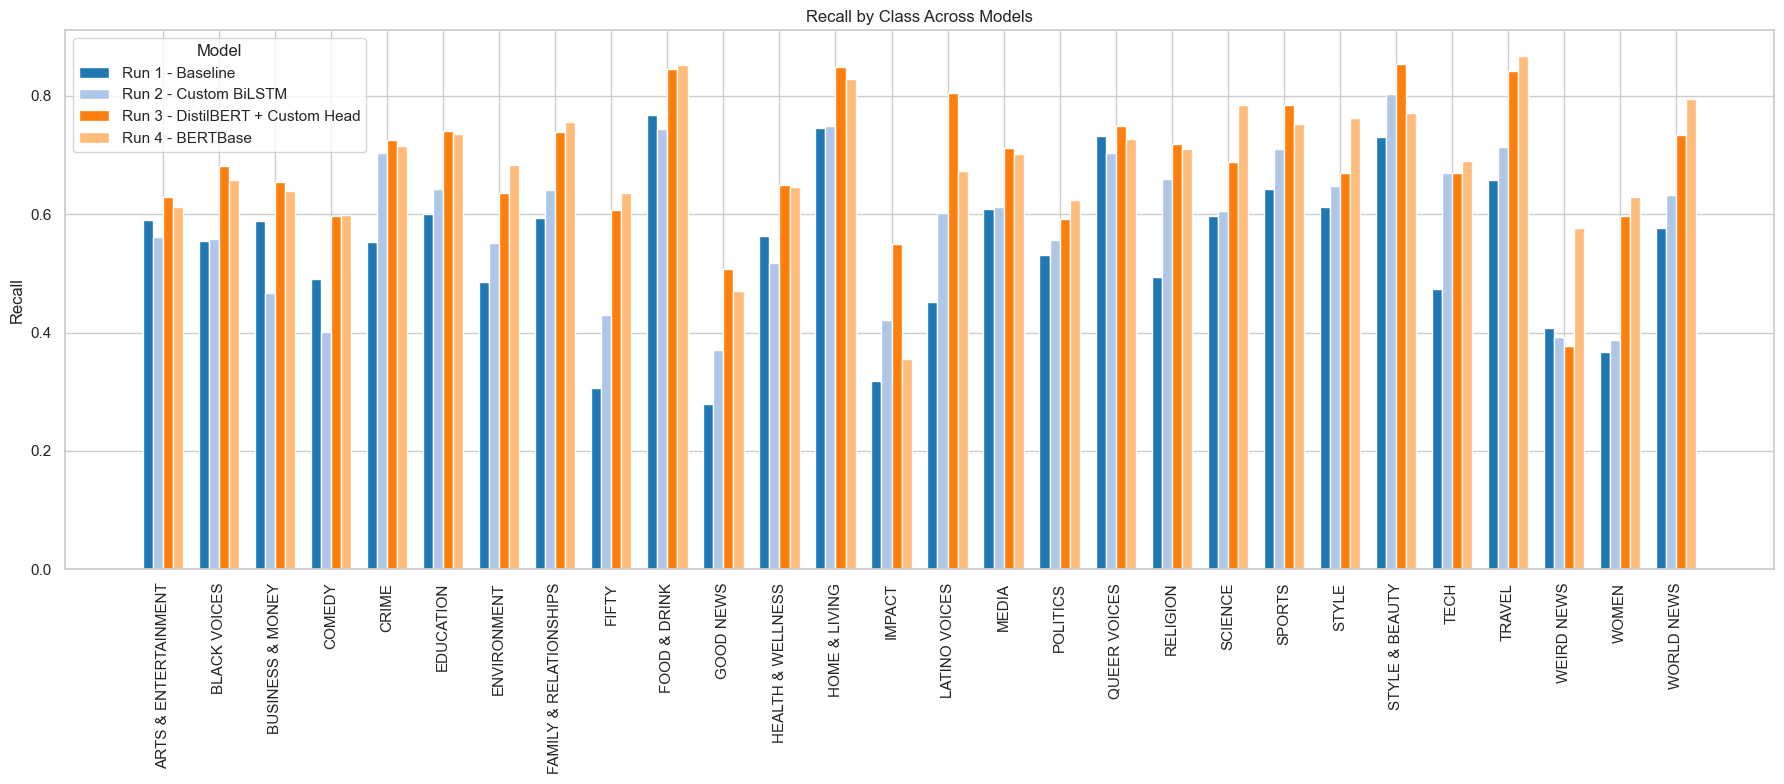

In [141]:
class_recall_comparison

2. **Trade-Offs:** Discuss how complexity, accuracy, and efficiency balanced across your models.

5.2. **Your answer here:**

There was a clear tradeoff between model complexity (measured here in parameters), computational cost, and predictive performance across our four models: 


| Model                | Parameters     | Run Time (A100) |Epochs    | Time per Epoch (A100)  | Test Accuracy  | Macro F1    |
|----------------------|----------------|---------------|------------| -----------------------|----------------|-------------|
| Model 1 - Baseline   | 1,931,932      |  1.35 minutes  | 26        |     0.052 m / e        |  0.5794        | 0.4975      |
| Model 2 - BiLSTM     | 4,176,156      | 1.78  minutes |  7         |     0.25 m / e         |  0.5946        | 0.5166      |
| Model 3 - DistilBERT | 66,566,940     | 39.35 minutes| 6           |     6.55 m / e         | 0.6856         | 0.6141      |
| Model 4 - BertBASE   | 109,686,300    | 48.59 minutes | 4          |     12.14 m / e.       | 0.6893         | 0.6153      |



While moving from the baseline and BiLSTM models to the transformer based models yielded a ~10% accuracy bump and a + ~10-12 points in Macro F1, moving from DistilBERT to BERT Base only increased performance by 0.3% in accuracy and 0.0012 in Macro F1. These differences are practically negligible, suggesting that the added ~40 million parameters did not translate into proportionally higher performance. 

That being said, training time increased pretty dramatically with the larger models, as the smaller models took ~6 and ~20 minutes to train respectively, while the transformer-based models took longer at 39 minutes-on-average for the DistillBERT and ~49 minutes for the BERT Base model, so while the transformer models converged in less epochs, their per-epoch cost made the run time significantly longer. 

Regarding convergence: 

- Baseline converged in 26 epochs (early stopping)
- BiLSTM converged in 7 epochs (early stopping)
- DistilBERT converged in 6 epochs (hard capped at 6 epochs for time even though the model had early stopping)
- BERT Base converged in 4 epochs (hard capped at 4 epochs for time even though the model had early stopping)

This overall reflects the strength of using contextual representations for this task as the BiLSTM and Transformer based architectures converged  much quicker and performed better than baseline, with better performance being roughly proportional to the degree of contextual embedding, and these models did not need many passes to find a good optimum. 

Overall, our DistilBERT model was the clear winner in terms of balancing greater accuracy with less parameters, and showing the best performance on the largest number of classes (16/28) while training in nearly half the time of the BERT base model on average. Though we should note that one of our DistilBERT runs took 149 minutes, despite no significant changes to code from previous runs (We figured that this was most likely due to a scheduling / resource availability conflict as other runs were far faster and aligned with expected expected runtimes, including a re-run of everything on an A100 GPU). 



3. **Error Patterns:** Describe the types of examples or classes that remained challenging for all models.

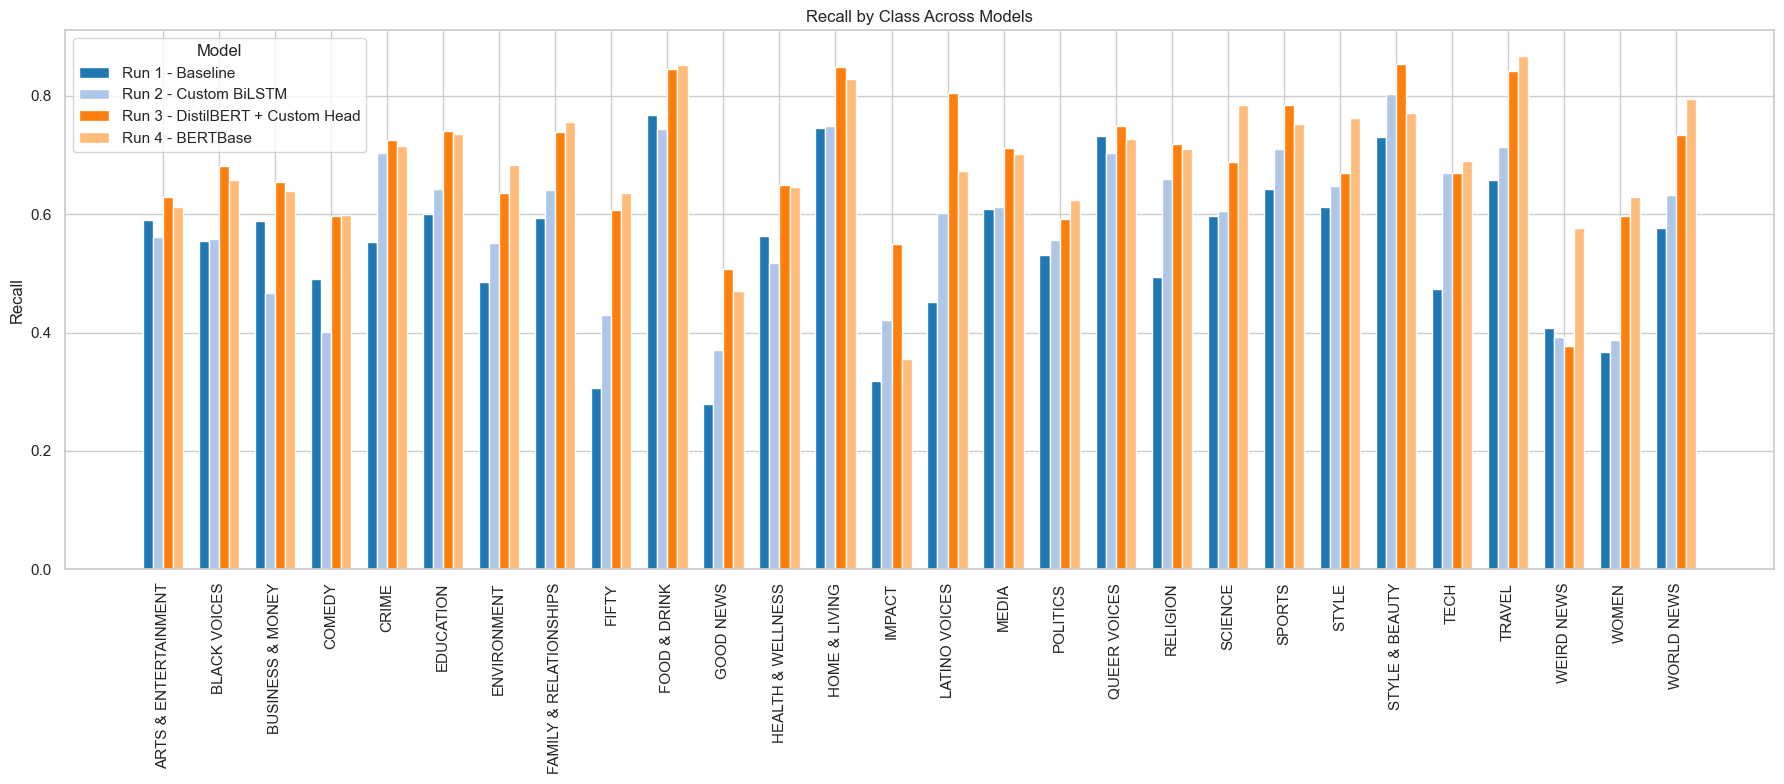

In [12]:
class_recall_comparison

5.3. **Your answer here:**



Across all models, a consistent set of categories remained challenging to classify, as shown again in the chart above. The categories that exhibited this low recall regardless of model architecture were: 

- Fifty (~35 - 60% recall)
- Impact (~30 - 55% recall)
- Weird News (~38 % - 58% recall)
- Good News (~28% - 50% recall)
- Women (~38 - 62% recall)

Each of these categories share several properties that make them difficult for text-based classification. Firstly, they have a high semantic overlap with other categories: For example, 'Impact' can relate to politics, environment and social issues; 'Women' articles could feature issues regarding health and wellness, relationships, or politics (all other categories), and Fifty (Life after 50) could overlap with Health and Wellness and Family and Relationships). These categorical overlaps likely increase Jaccard similarity between these categories and multiple others, which makes them harder to classify for all models. 

Additionally, broad, nebulous categories like 'Impact' and 'Good News' and 'Weird News' are hard to distiguish because they're distinguished more by editorial or reader perception, and not purely by textual cues. As a result, these stories can vary widely in topic which undermines the basis for how our models are performing classification task. So even though our transformer based classifiers improved performance overall, these categories remained challenging because of these challenges. 

4. **Next Steps:** Based on these findings, decide on a model to go forward with and outline your plan for improving that model.


5.4 **Your answer here:**


Based on our findings here, the model that we will go forward with is the DistilBERT. This model consistently maintained the best balance of overall efficiency and performance. As a review: 
- It achieved 0.6856 on accuracy and 0.6141 on macro F1 - outperforming both baseline models.
- It performed best in 16 out of 28 categories in within-class recall.
- It trained in roughly half the time of BERT Base on average. 

And because of these strong performance-efficiency tradeoffs, DistilBERT is the most promising fondation for further fine-tuning. Going forward, our strategy will be to implement the following strategies in order to improve our model performance: 

- **1. Experiment with learning rates, dropout, and reduce on pleatau scheduling.** This will help stabilize the model and ameliorate any overfitting patterns as we experiment with deeper classification heads or unfrozen layer configurations. 

- **2. Deeper Architectural Head Designs:** Our current classification head architecture is intentionally simple (256 unit -> dropout -> softmax). A deeper architectural design (a 512 -> 256 -> 128 unit classification head with dropout, for example) is expected to yield a modest increase in model performance, going off of past performance gains.

- **3. Early Stopping Implementation:** Though DistilBERT performed the best overall so far, it did so with a hard cap on the number of epochs that it was able to run through (4-6). Implementing an early stopping framework with our model will allow it to automatically find the optimal amount of Epochs  and avoid underfitting as we experiment with more architectural changes. 

- **4. Data Augmentation:** For categories that all models struggled with classifying (Fifty, Impact, Weird News, Women, etc.) we can implement a data augmentation strategy in any of the following ways: 
    - Back-Tanslation of underrepresented categories
    - LLM Synthetic generation of semantically challenging categories with a prompt that preserves category-specific meaning
    - LLM Hard negative generation (edge case examples from adjacent categories). 

- **5. Experiment with Unfreezing the DistilBERT Transformer with varying depths:** We could also explore selectively unfreezing parts of the DistilBERT transformer at varying depths to capture more nuances in the dataset. While we unfroze the entire backbone for this task, a different unfrozen configuration here could yield better sensitivity to the dataset while protecting against overfitting. 


Taken together, these steps provide a clear and structured roadmap for maximizing our model's performance moving forward. 

### Final Question: Describe what use you made of generative AI tools in preparing this Milestone.

**AI Question: Your answer here:**

In preparing this milestone, we used generative AI tools (ChatGPT-5) to support us in several ways. For Problems 1–3, we primarily relied on ChatGPT to help refine and debug our code, especially when adapting snippets from previous homeworks to the structure required in this assignment. Additionally, for problems 4-5 we used ChatGPT for additional debugging support, for selecting seaborn theme / color plotting choices, and to pull our printed results from throughout the milestone into a cohesive table (via regex) for data and results visualization. 

In addition, we used ChatGPT to improve the clarity and structure of our written markdown answers. We provided our own draft explanations and asked the model to help reorganize sentences, improve readability, and keep the tone concise and consistent across sections. All conceptual reasoning, model choices, and analysis were decided by us; the AI tool mainly assisted with phrasing and polishing our work.

